In [3]:
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2
import os
print(os.getcwd())
os.chdir('/home/vco/Projects/pm4py-dcr') # working directory should be pm4py-dcr (the one behind notebooks)
print(os.getcwd())

os.environ['PM4PY_SHOW_EVENT_LOG_DEPRECATION'] = 'false'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/vco/Projects/pm4py-dcr
/home/vco/Projects/pm4py-dcr


In [4]:
import pm4py
import matplotlib as mpl                # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
import numpy as np
import pandas as pd
import datetime as dt
import pickle
from copy import deepcopy
from fitter import Fitter, get_common_distributions, get_distributions
from distfit import distfit
from pm4py.util.benchmarking import benchmark_event_log_from_configs
from pm4py.algo.discovery.dcr_discover.algorithm import Variants
from pm4py.algo.discovery.dcr_discover.extenstions import time_constraints
from pm4py.util.external_functions import Chi2Regression
from pm4py.util.external_functions import *
from iminuit import Minuit,cost                             # The actual fitting tool, better than scipy's
# useful functions to print fit results on figure
pm4py.util.constants.SHOW_EVENT_LOG_DEPRECATION = False
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

In [5]:
r = np.random                         # Random generator
r.seed(1)                            # Set a random seed (but a fixed one - more on that later.)

save_plots = False

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

In [6]:
event_log_file = '/home/vco/Datasets/12683249/Road_Traffic_Fine_Management_Process.xes'
dcr_title = 'Traffic Fine'
result_file_prefix = 'traffic_fine'

config = [{
            'timed': False,
            'pending': False,
            'variant': Variants.DCR_BASIC
        }]

rtfmp_dcrs = benchmark_event_log_from_configs(event_log_file,result_file_prefix,dcr_title,config)
log = pm4py.read_xes(event_log_file)
dcr_model = rtfmp_dcrs[0]

parsing log, completed traces ::   0%|          | 0/150370 [00:00<?, ?it/s]

[i] Started with config: {'timed': False, 'pending': False, 'variant': <Variants.DCR_BASIC: <module 'pm4py.algo.discovery.dcr_discover.variants.dcr_discover' from '/home/vco/Projects/pm4py-dcr/pm4py/algo/discovery/dcr_discover/variants/dcr_discover.py'>>}
[i] Mining with basic DisCoveR
[!] Model saved in models/traffic_fine__config0.xml


parsing log, completed traces ::   0%|          | 0/150370 [00:00<?, ?it/s]

In [7]:
dcr_model = rtfmp_dcrs[0]
dcr_model

{'events': {'Add penalty',
  'Appeal to Judge',
  'Create Fine',
  'Insert Date Appeal to Prefecture',
  'Insert Fine Notification',
  'Notify Result Appeal to Offender',
  'Payment',
  'Receive Result Appeal from Prefecture',
  'Send Appeal to Prefecture',
  'Send Fine',
  'Send for Credit Collection'},
 'conditionsFor': {'Insert Date Appeal to Prefecture': {'Create Fine'},
  'Create Fine': set(),
  'Send Appeal to Prefecture': {'Create Fine'},
  'Receive Result Appeal from Prefecture': {'Send Fine'},
  'Notify Result Appeal to Offender': {'Insert Fine Notification'},
  'Add penalty': {'Insert Fine Notification'},
  'Send for Credit Collection': {'Add penalty'},
  'Payment': {'Create Fine'},
  'Send Fine': {'Create Fine'},
  'Insert Fine Notification': {'Send Fine'},
  'Appeal to Judge': {'Create Fine'}},
 'milestonesFor': {'Insert Date Appeal to Prefecture': set(),
  'Create Fine': set(),
  'Send Appeal to Prefecture': set(),
  'Receive Result Appeal from Prefecture': set(),
  'Notif

In [206]:
# all_timings = time_mining.get_timing_values(dcr_model=dcr_model, event_log=log, sp_log=None)
all_timings = time_constraints.get_all_timings(event_log=log)
with open('datasets/all_timings_all.pkl', 'wb') as f:
    pickle.dump(all_timings, f)

In [6]:
with open('datasets/all_timings_all.pkl', 'rb') as f:
    loaded_timings = pickle.load(f)
loaded_timings.keys()

dict_keys([('Send Fine', 'Send for Credit Collection'), ('Add penalty', 'Receive Result Appeal from Prefecture'), ('Insert Date Appeal to Prefecture', 'Send for Credit Collection'), ('Send Appeal to Prefecture', 'Send for Credit Collection'), ('Create Fine', 'Send for Credit Collection'), ('Appeal to Judge', 'Create Fine'), ('Insert Date Appeal to Prefecture', 'Receive Result Appeal from Prefecture'), ('Payment', 'Send Appeal to Prefecture'), ('Payment', 'Send Fine'), ('Receive Result Appeal from Prefecture', 'Send Appeal to Prefecture'), ('Insert Fine Notification', 'Send for Credit Collection'), ('Receive Result Appeal from Prefecture', 'Send Fine'), ('Create Fine', 'Receive Result Appeal from Prefecture'), ('Appeal to Judge', 'Insert Fine Notification'), ('Appeal to Judge', 'Send for Credit Collection'), ('Insert Fine Notification', 'Receive Result Appeal from Prefecture'), ('Add penalty', 'Appeal to Judge'), ('Appeal to Judge', 'Receive Result Appeal from Prefecture'), ('Add penalt

In [31]:
min_time = log['time:timestamp'].min()
max_time = log['time:timestamp'].max()
log_duration = max_time - min_time
log_duration_days = log_duration.days
print(log_duration_days)

4916


In [32]:
events = log['concept:name'].unique()
print(events)

['Create Fine' 'Send Fine' 'Insert Fine Notification' 'Add penalty'
 'Send for Credit Collection' 'Payment' 'Insert Date Appeal to Prefecture'
 'Send Appeal to Prefecture' 'Receive Result Appeal from Prefecture'
 'Notify Result Appeal to Offender' 'Appeal to Judge']


In [33]:
cases_start = log[['case:concept:name','concept:name','time:timestamp']].groupby('case:concept:name')['time:timestamp'].min()
cases_end = log[['case:concept:name','concept:name','time:timestamp']].groupby('case:concept:name')['time:timestamp'].max()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


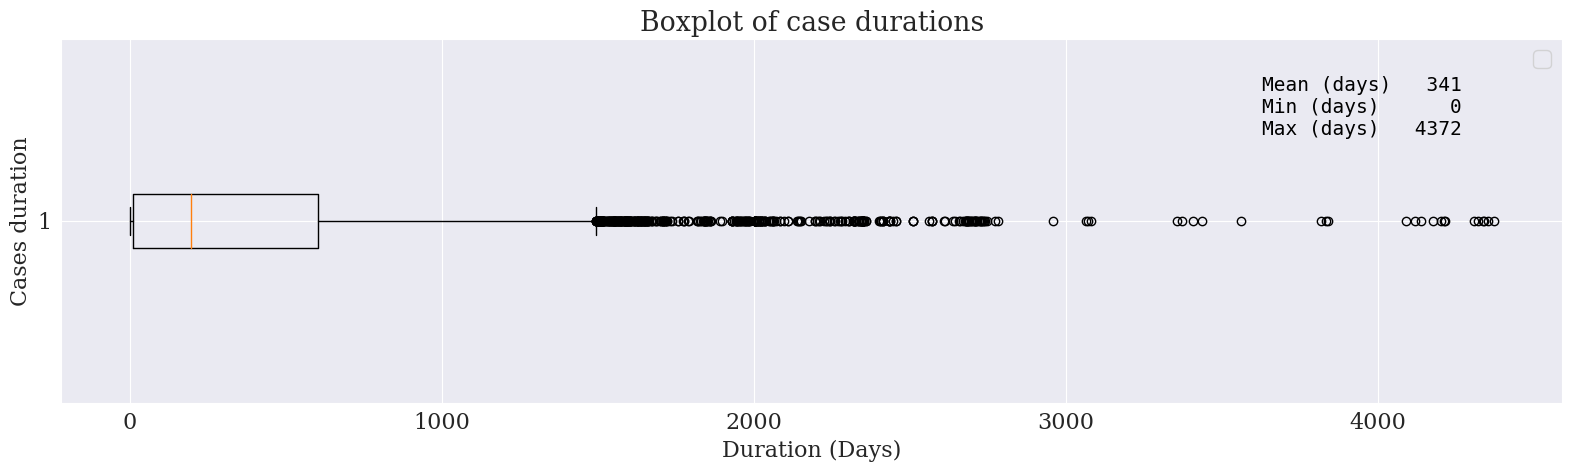

In [34]:
fig, ax = plt.subplots(figsize=(16, 5))
ax.boxplot((cases_end-cases_start).dt.days,vert=False)
d = {'Mean (days)':np.mean(cases_end - cases_start).days,
     'Min (days)': min(cases_end - cases_start).days,
     'Max (days)': max(cases_end - cases_start).days}
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.8, 0.9, text, ax, fontsize=14)
ax.set_xlabel('Duration (Days)')
ax.set_ylabel('Cases duration')
ax.set_title('Boxplot of case durations')
fig.tight_layout()
ax.legend()

# Event level in case timing information

In [60]:
def get_event_in_case_level_timing_information(event):
    event_time = log[log['concept:name']==event][['case:concept:name','time:timestamp']]
    event_relative_to_case = pd.merge(cases_start,event_time,on='case:concept:name',suffixes=("_case","_event"))
    event_relative_to_case['delta_t'] = event_relative_to_case['time:timestamp_event'] - event_relative_to_case['time:timestamp_case']
    return event_relative_to_case['delta_t']

In [61]:
all_events_in_case_timings = {}
for event in events:
    delta_t = get_event_in_case_level_timing_information(event)
    all_events_in_case_timings[event] = delta_t.dt.days

In [96]:
xmin = 0
xmax = 1000
density = True

Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 29.39it/s]


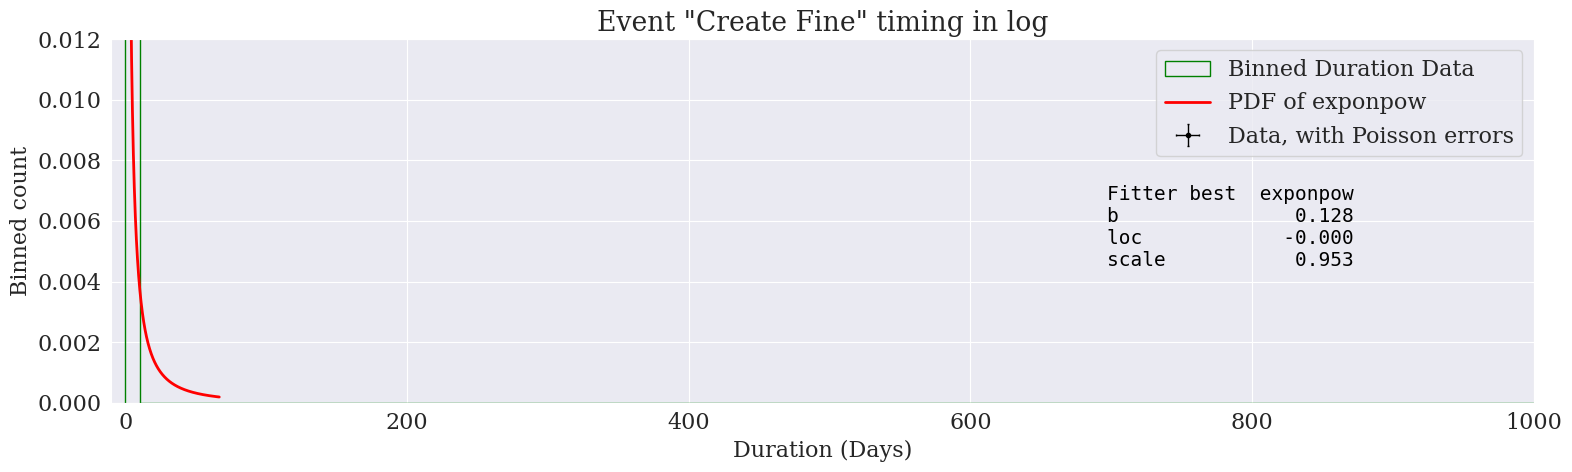

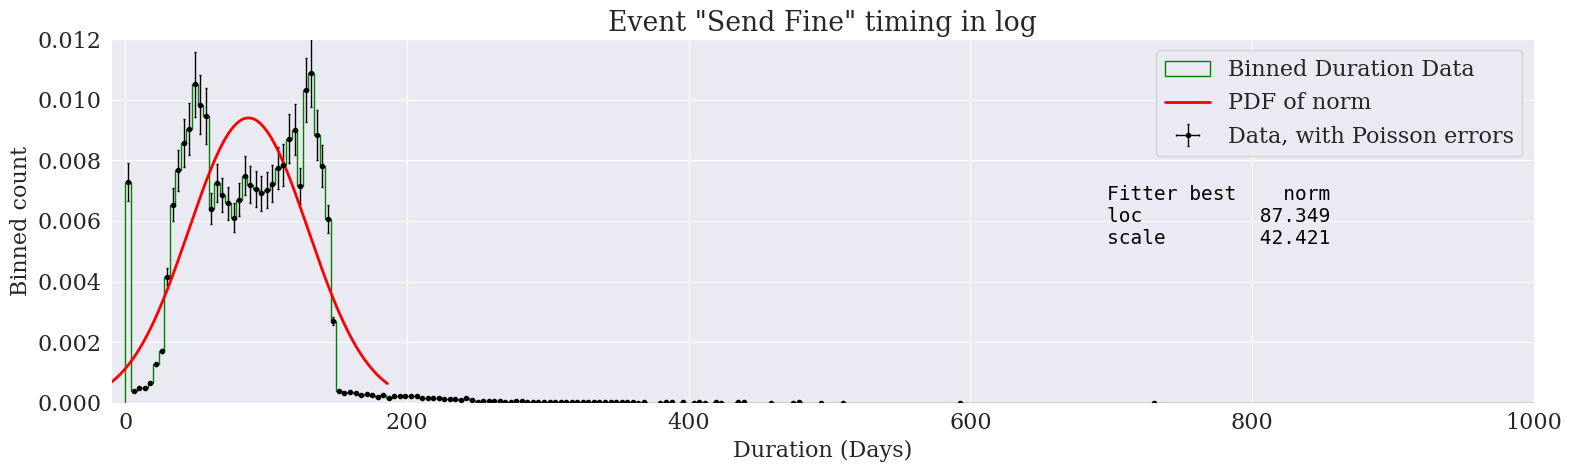

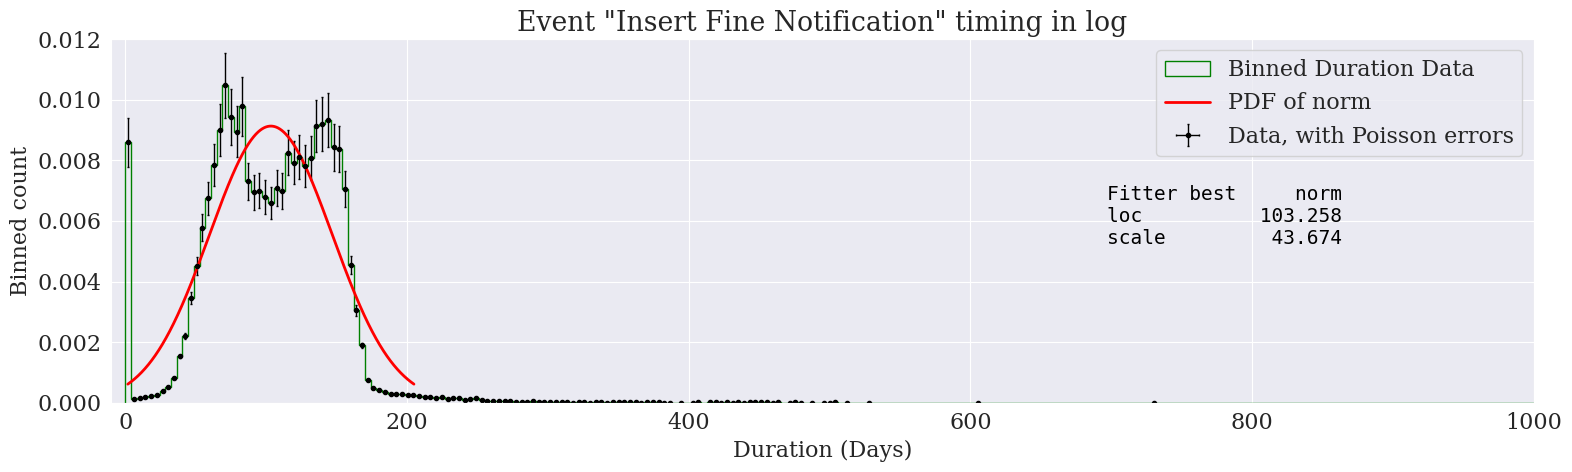

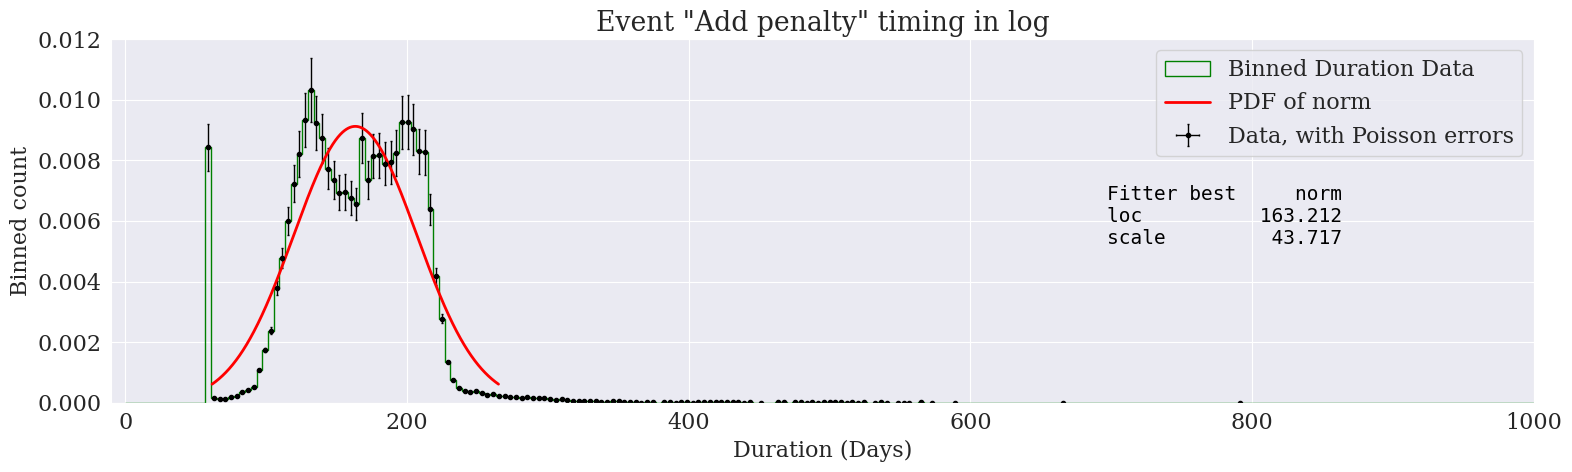

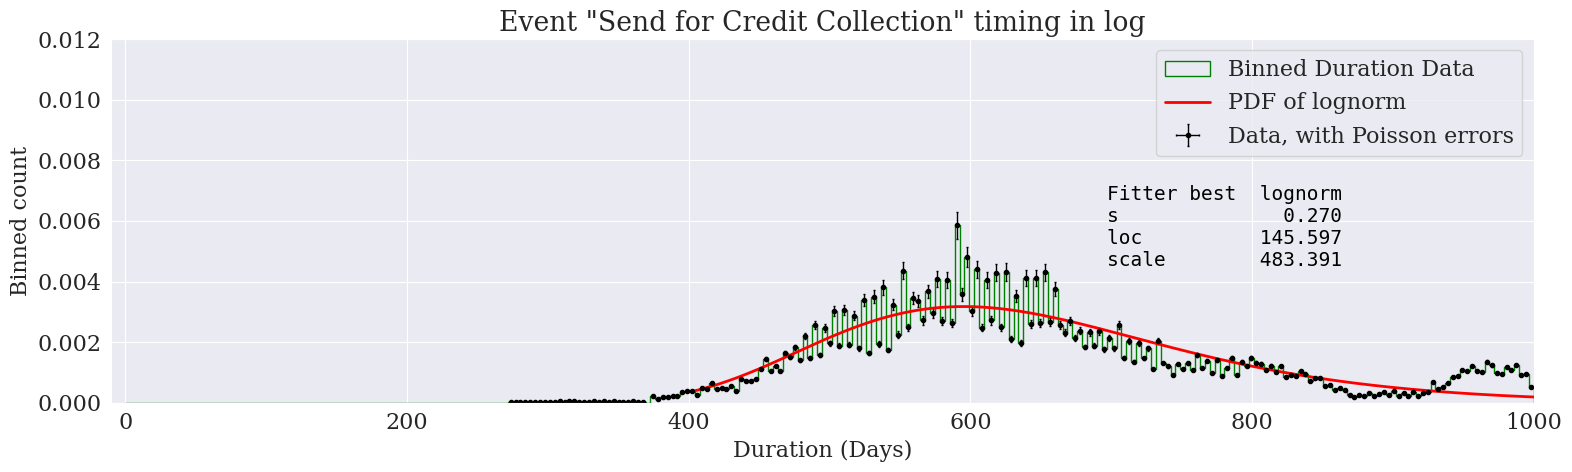

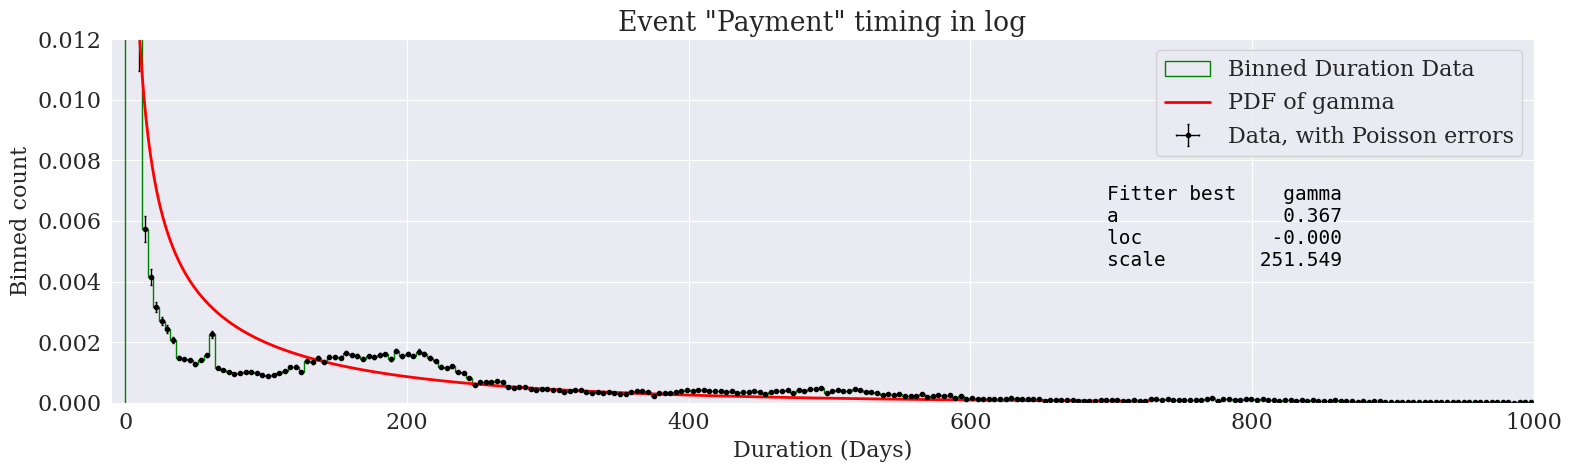

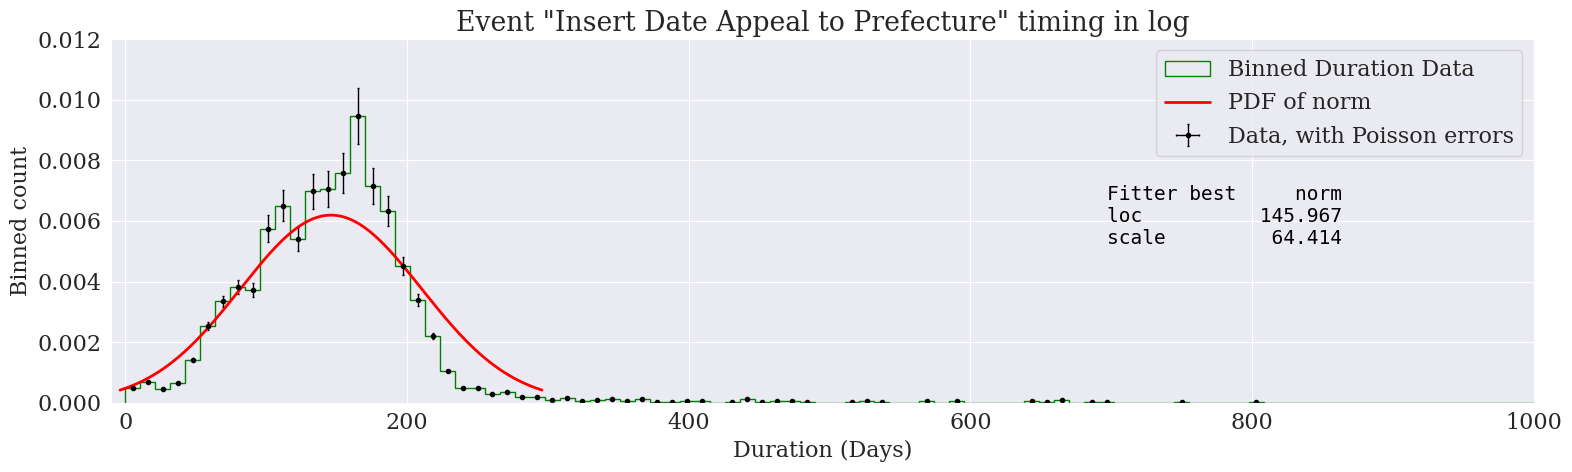

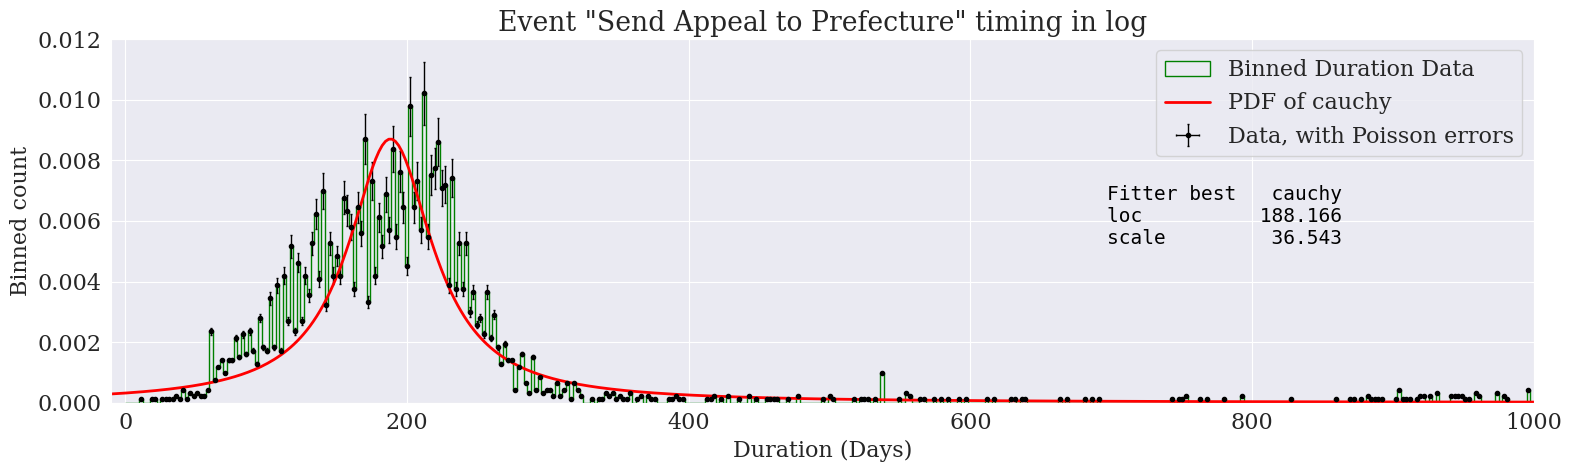

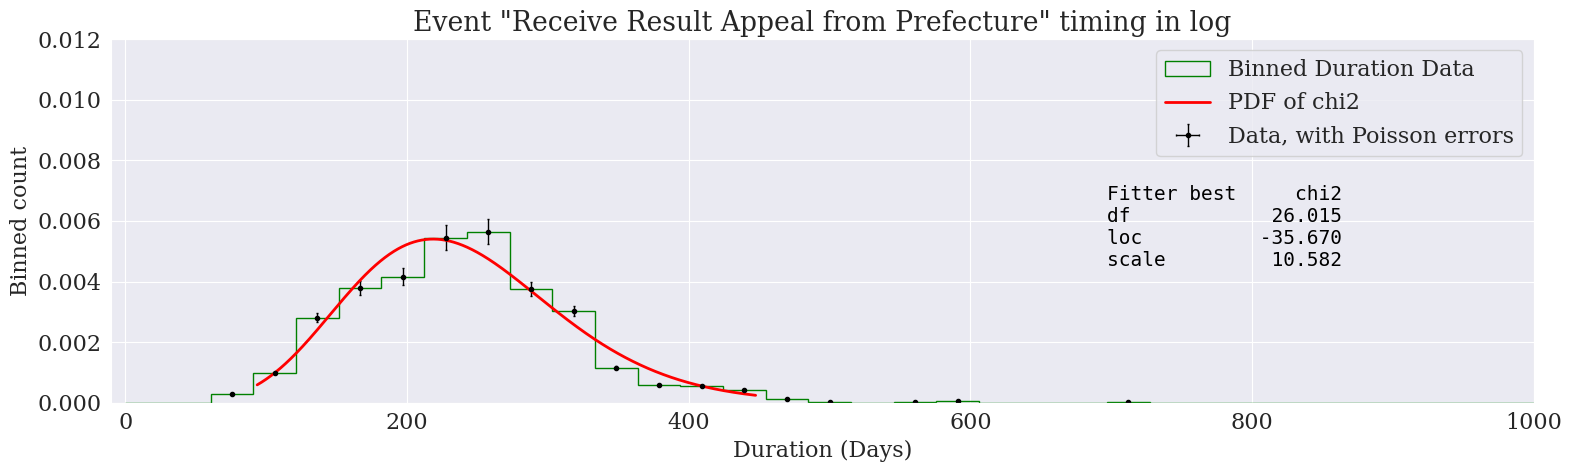

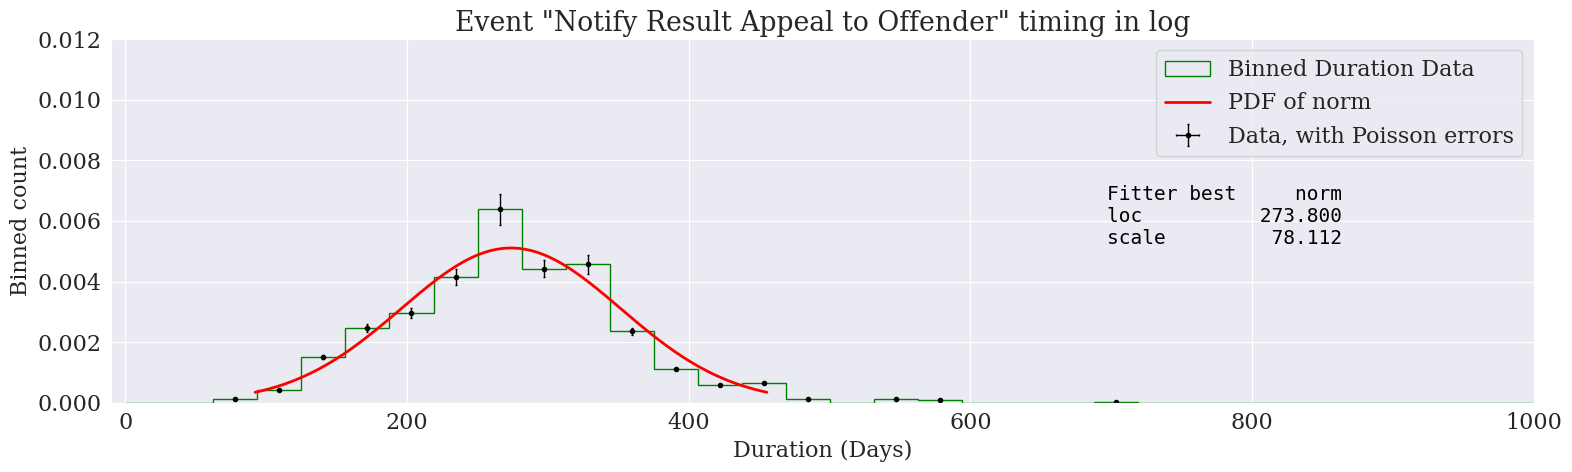

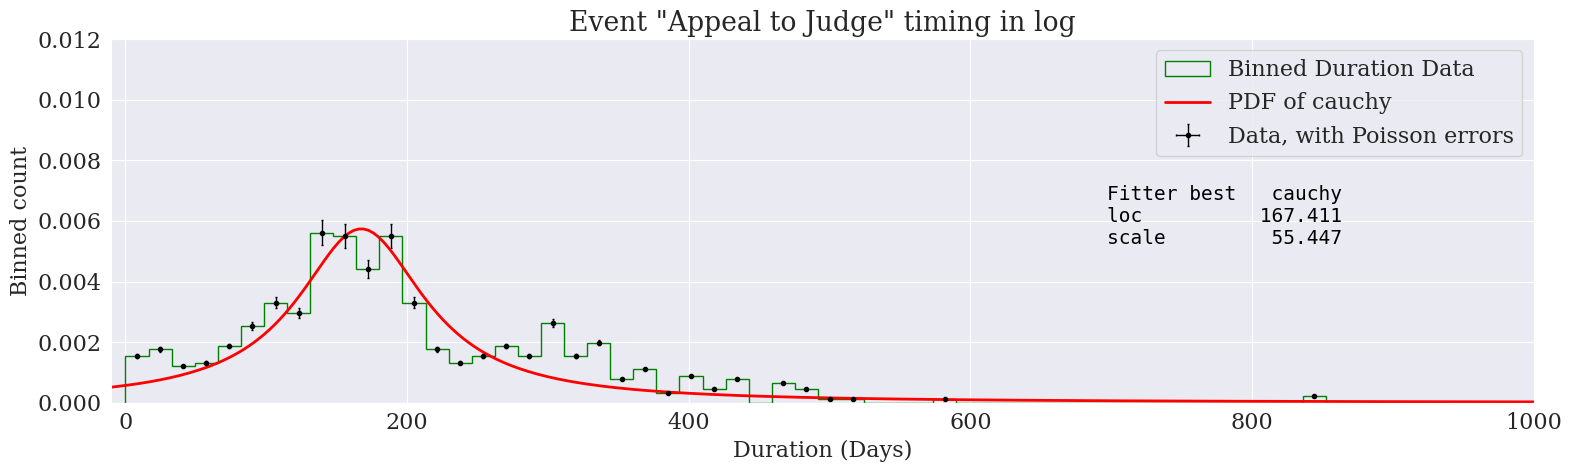

In [98]:
for event, timings in all_events_in_case_timings.items():
    Nbins, binwidth = freedman_diaconis_rule(timings)
    counts, bin_edges = np.histogram(timings, bins=Nbins, range=(xmin, xmax),density=density)
    x = (bin_edges[1:][counts > 0] + bin_edges[:-1][counts > 0]) / 2
    y = counts[counts > 0]
    sy = np.sqrt(counts[counts > 0])
    if density:
        sy = sy*counts[counts > 0]
    fig, ax = plt.subplots(figsize=(16, 5))
    counts, bins, bars = ax.hist(timings, bins=Nbins, range=(xmin, xmax), histtype='step',
                                                     density=density, alpha=1, color='g',
                                                     label='Binned Duration Data')
    ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',
                                   ecolor='k',
                                   elinewidth=1, capsize=1, capthick=1)
    f = Fitter(timings, distributions=get_common_distributions(),xmax=xmax,timeout=2*60,bins=Nbins,density=density)
    f.fit()
    # here you get the rss fit scores
    res = f.summary(plot=False)
    residual_sumssquare_error = res.iloc[0].sumsquare_error
    aic = res.iloc[0].aic
    kl_div = res.iloc[0].kl_div
    best_dist, fitted_params = f.get_best().popitem()

    size = 1000
    dist_func = getattr(stats,best_dist)
    start = dist_func.ppf(0.01, **fitted_params)
    end = dist_func.ppf(0.99, **fitted_params)
    x = np.linspace(start, end, size)
    y = dist_func.pdf(x, **fitted_params)
    pdf = pd.Series(y, x)
    pdf.plot(lw=2, label=f'PDF of {best_dist}', color='r', legend=True)

    # ax.plot(f.fitted_pdf[best_dist],label=f'Best fit {best_dist}')
    d = {'Fitter best':f'{best_dist}',
         **fitted_params}
    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.7, 0.6, text, ax, fontsize=14)
    ax.set_xlabel('Duration (Days)')
    ax.set_ylabel('Binned count')
    ax.set_xlim([xmin-10,xmax])
    ax.set_ylim([0,0.012])
    ax.set_title(f'Event "{event}" timing in log')
    ax.legend()
    fig.tight_layout()

# Event level to other event timing information

Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 28.63it/s]


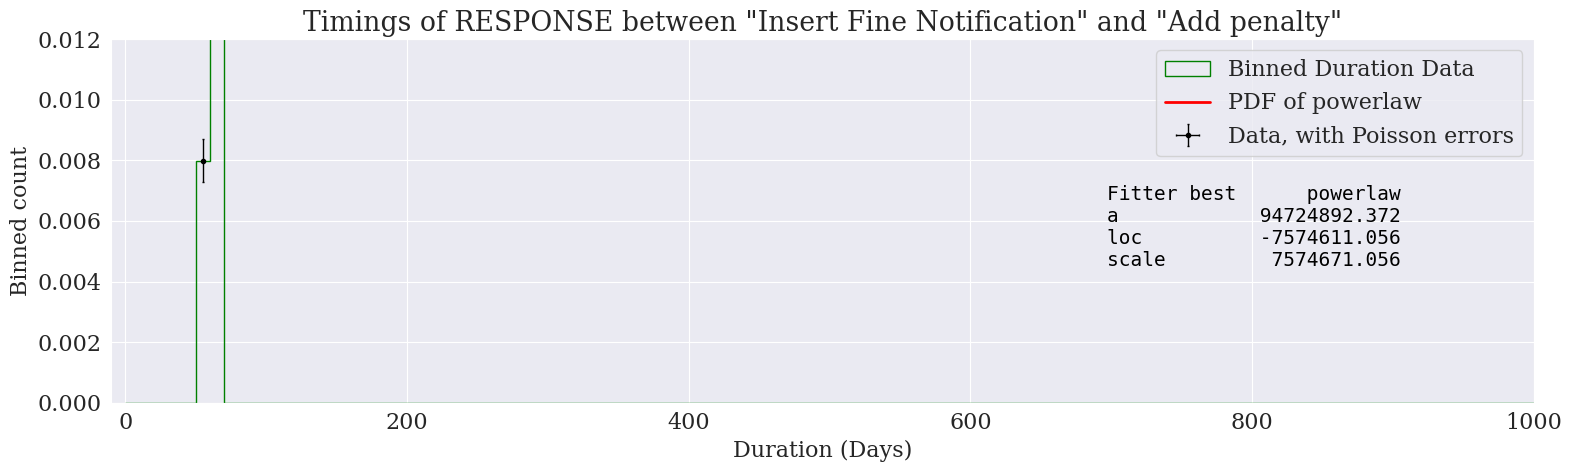

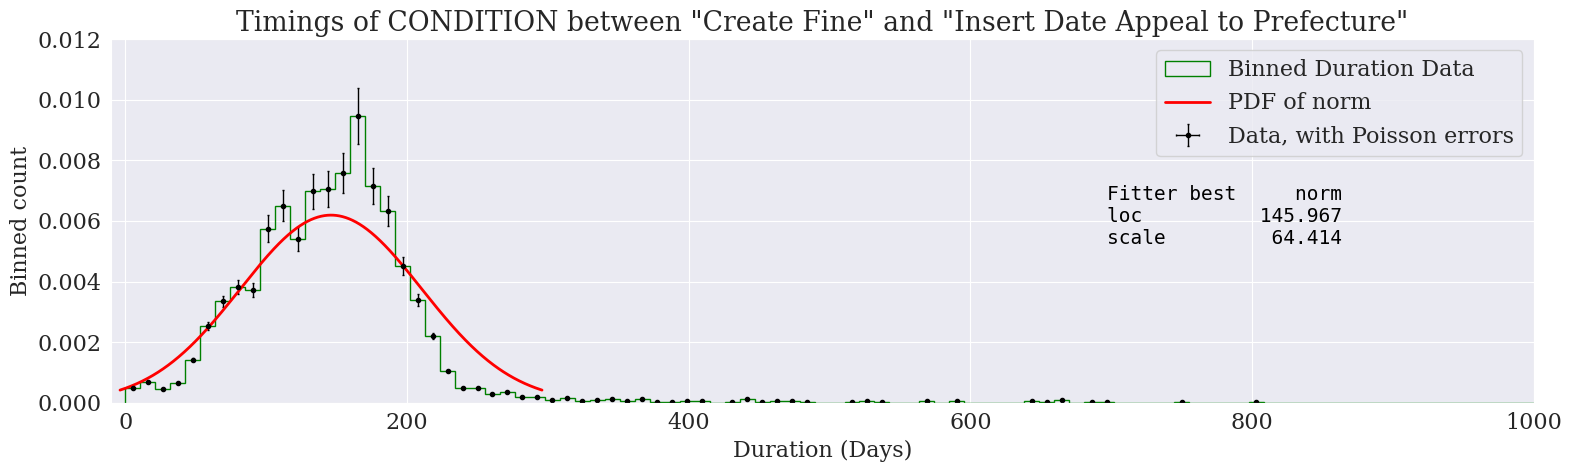

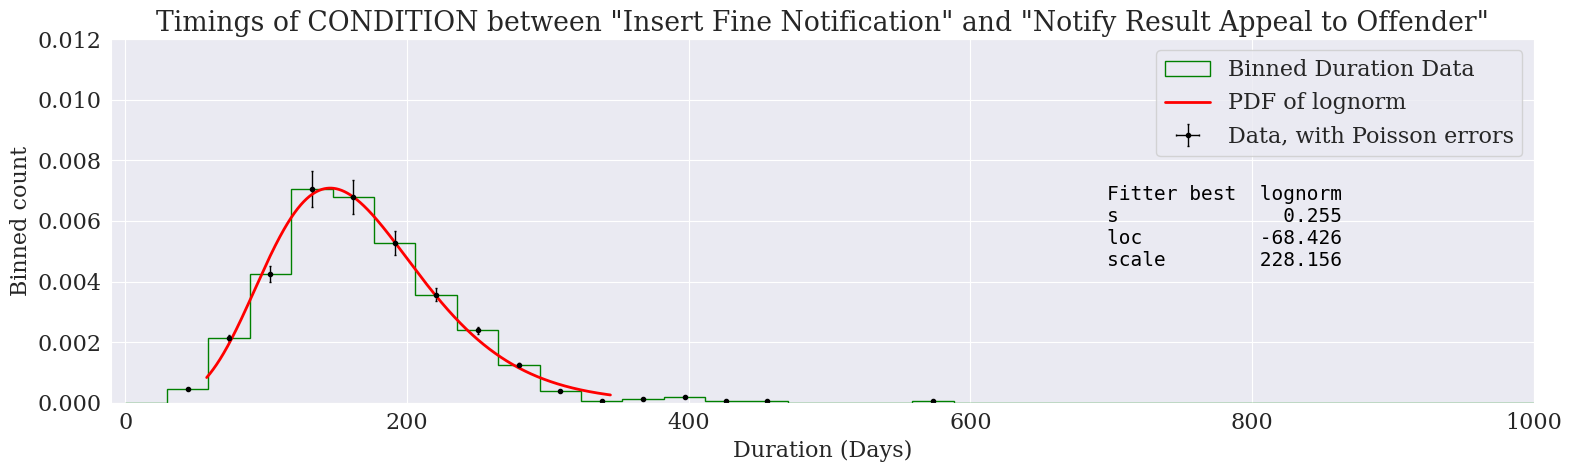

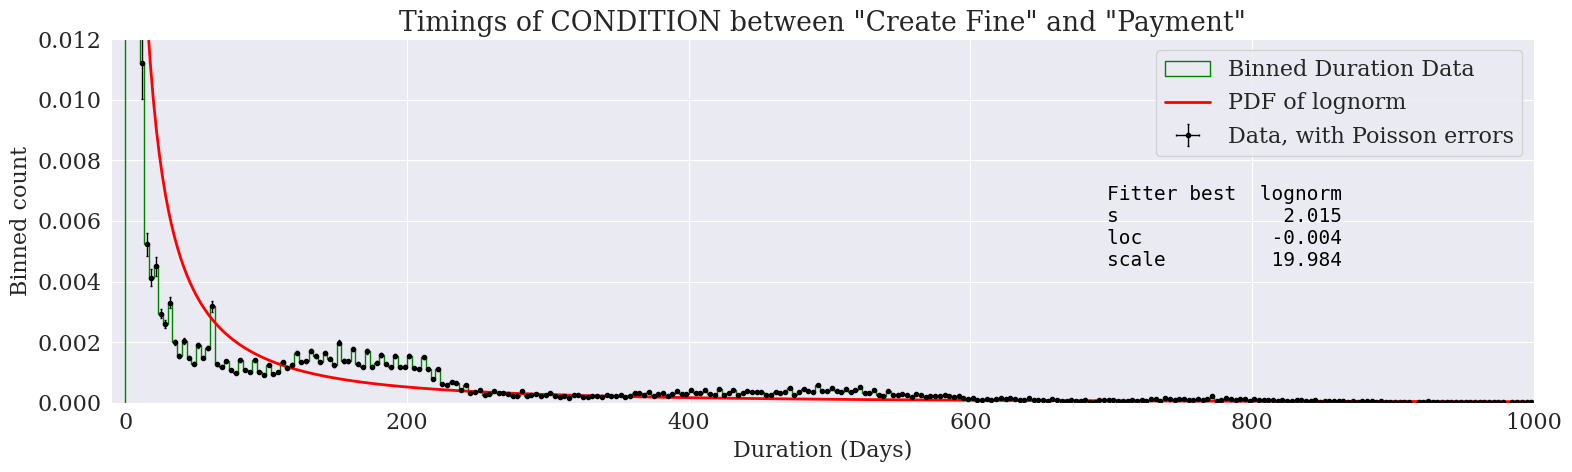

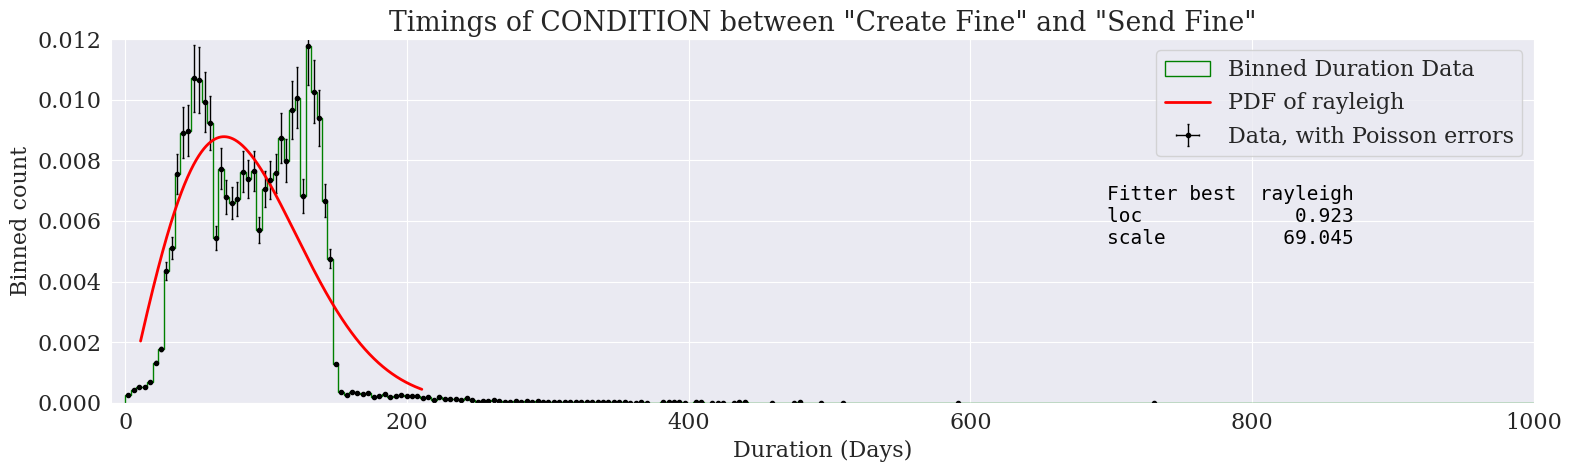

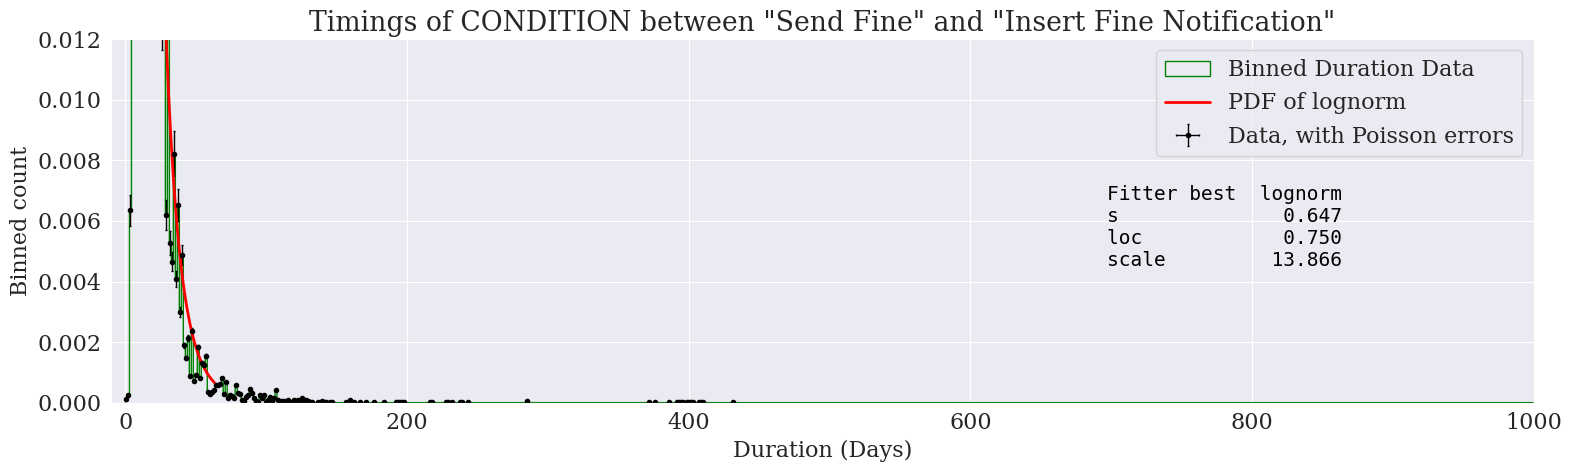

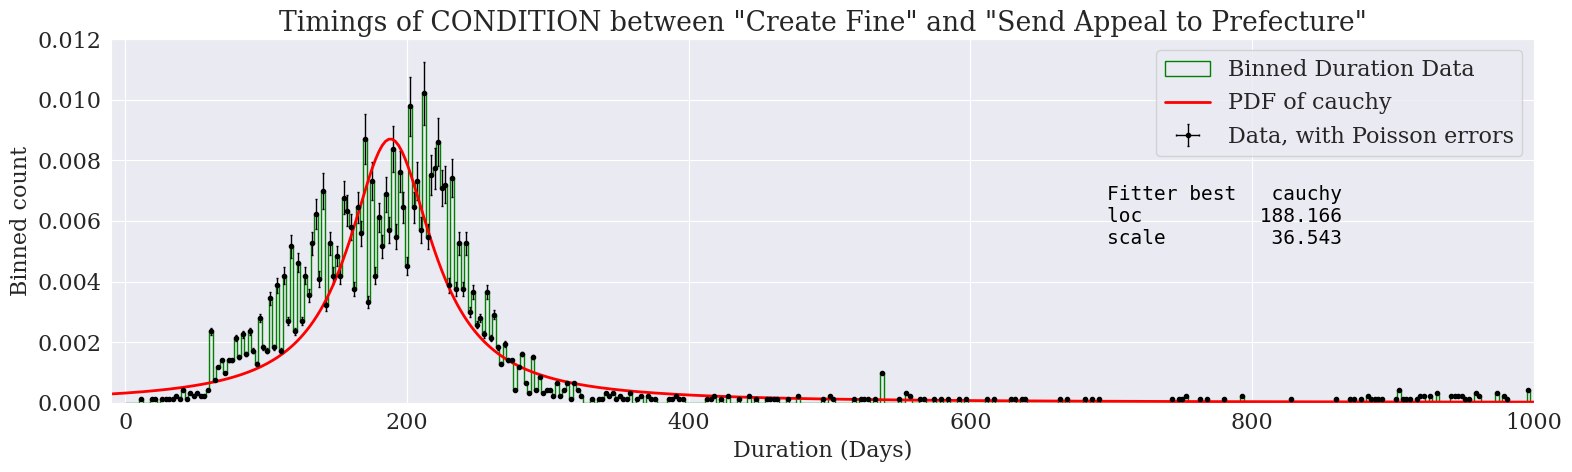

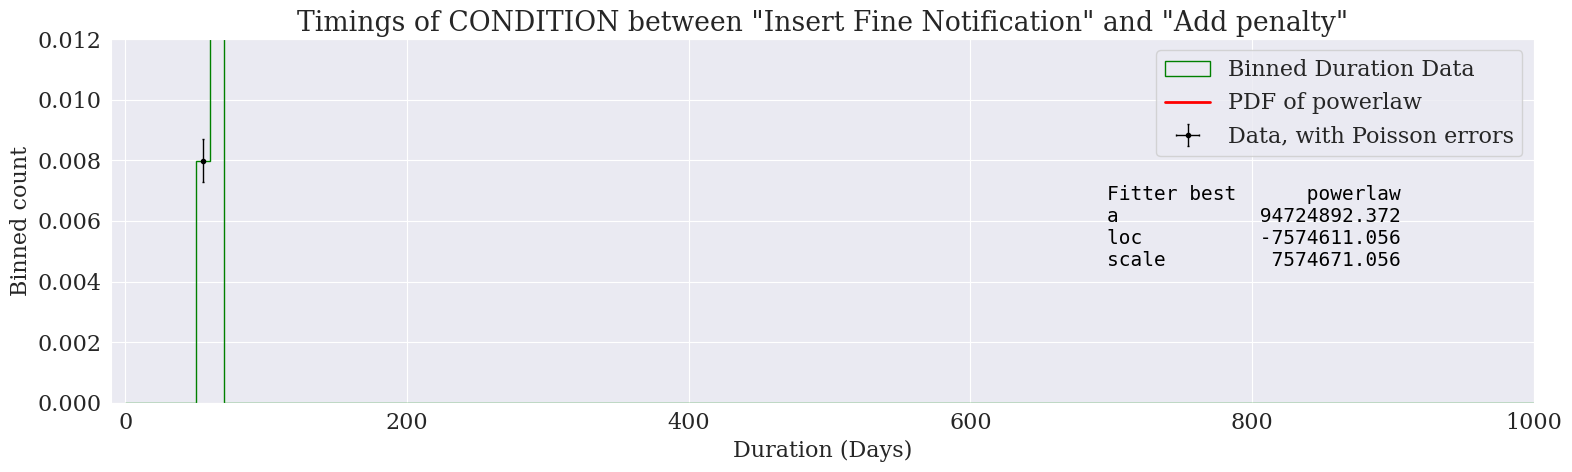

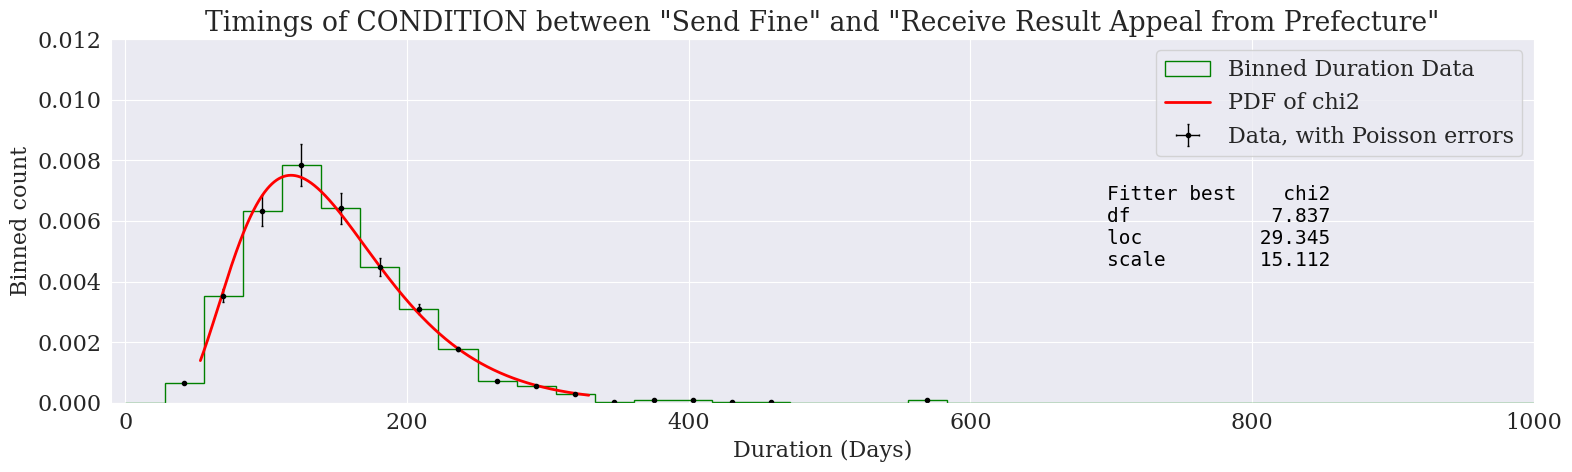

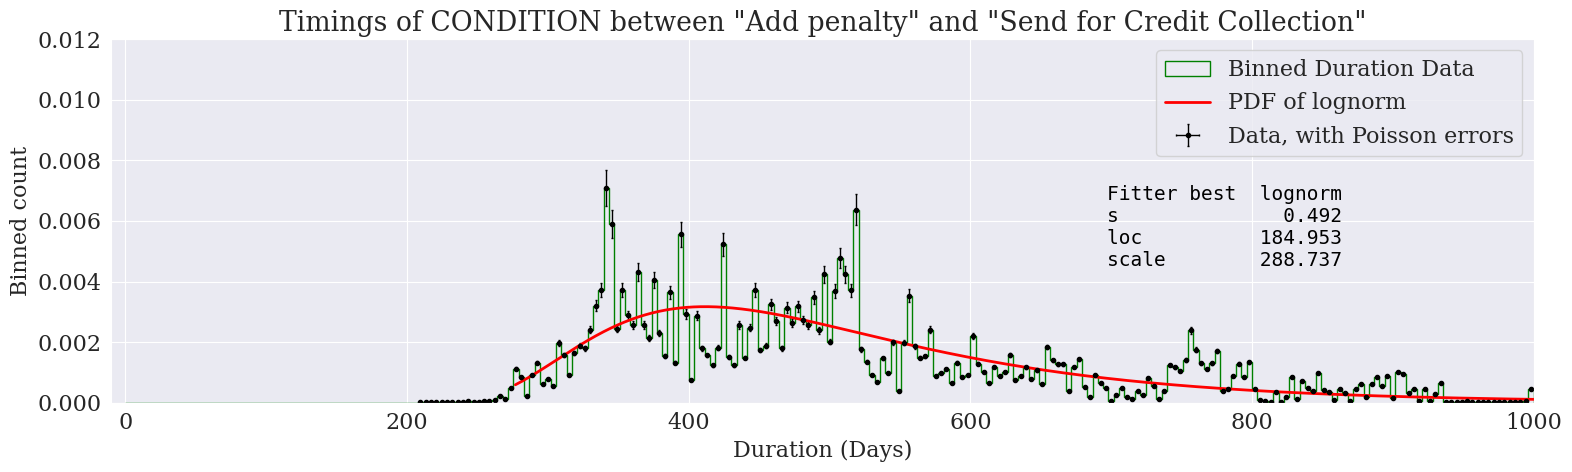

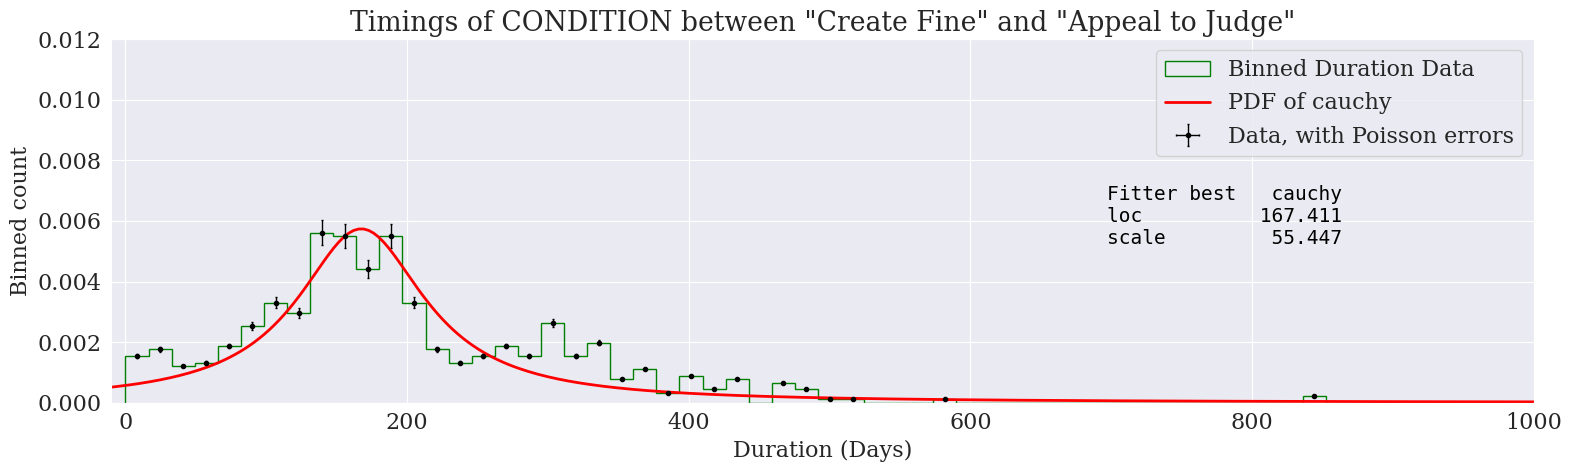

In [101]:
for (rule,e1,e2), timedeltas in loaded_timings.items():
    timings = np.asarray([x.days for x in timedeltas],dtype=int)

    Nbins, binwidth = freedman_diaconis_rule(timings)
    counts, bin_edges = np.histogram(timings, bins=Nbins, range=(xmin, xmax),density=density)
    x = (bin_edges[1:][counts > 0] + bin_edges[:-1][counts > 0]) / 2
    y = counts[counts > 0]
    sy = np.sqrt(counts[counts > 0])
    if density:
        sy = sy*counts[counts > 0]
    fig, ax = plt.subplots(figsize=(16, 5))
    counts, bins, bars = ax.hist(timings, bins=Nbins, range=(xmin, xmax), histtype='step',
                                                     density=density, alpha=1, color='g',
                                                     label='Binned Duration Data')
    ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',
                                   ecolor='k',
                                   elinewidth=1, capsize=1, capthick=1)
    f = Fitter(timings, distributions=get_common_distributions(),xmax=xmax,timeout=2*60,bins=Nbins,density=density)
    f.fit()
    # here you get the rss fit scores
    res = f.summary(plot=False)
    residual_sumssquare_error = res.iloc[0].sumsquare_error
    aic = res.iloc[0].aic
    kl_div = res.iloc[0].kl_div
    best_dist, fitted_params = f.get_best().popitem()

    size = 1000
    dist_func = getattr(stats,best_dist)
    start = dist_func.ppf(0.01, **fitted_params)
    end = dist_func.ppf(0.99, **fitted_params)
    x = np.linspace(start, end, size)
    y = dist_func.pdf(x, **fitted_params)
    pdf = pd.Series(y, x)
    pdf.plot(lw=2, label=f'PDF of {best_dist}', color='r', legend=True)

    # ax.plot(f.fitted_pdf[best_dist],label=f'Best fit {best_dist}')
    d = {'Fitter best':f'{best_dist}',
         **fitted_params}
    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.7, 0.6, text, ax, fontsize=14)
    ax.set_xlabel('Duration (Days)')
    ax.set_ylabel('Binned count')
    ax.set_xlim([xmin-10,xmax])
    ax.set_ylim([0,0.012])

    ax.set_title(f'Timings of {rule} between "{e1}" and "{e2}"')
    ax.legend()
    fig.tight_layout()

# Create more advanced functions for better fits

# Mathematical definition
Create all events as a RV and link the event occurence with the pdf of the event and the pdf of the relation

In [144]:
# each event has a 50% chance of occurring by default or a p chance
event_functions = {}
for event in events:
    print(event)
    event_functions[event] = lambda p: r.choice([1,0],p=[p,(1-p)]) if p else r.choice([1,0])

Create Fine
Send Fine
Insert Fine Notification
Add penalty
Send for Credit Collection
Payment
Insert Date Appeal to Prefecture
Send Appeal to Prefecture
Receive Result Appeal from Prefecture
Notify Result Appeal to Offender
Appeal to Judge


In [204]:
# at runtime the probability of an event to fire changes as you execute the trace
p = 0.5
event_functions['Create Fine'](p)

0

In [ ]:
# p can be a more advanced function. you can sample from a pdf for example

In [ ]:
# p can also be dependent on the prob of other events firing
# p_e1 = a*p_e2 + N_e1 where a is a coefficient, p_e2 is the prob of another event firing and N_e1 is random noise.
# must make sure it is still a probability distribution

# Try ICP

In [12]:
import sempler, sempler.generators
import matplotlib.pyplot as plt
import numpy as np
import causalicp as icp
np.random.seed(12)
import networkx as nx

def show_graph_with_labels(adjacency_matrix, mylabels = None):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.DiGraph()
    gr.add_edges_from(edges)
    if mylabels:
        nx.draw(gr, node_size=500, labels=mylabels, with_labels=True)
    else:
        nx.draw(gr, node_size=500, with_labels=False)
    plt.show()

# Generate a random graph and construct a linear-Gaussian SCM
# W = sempler.generators.dag_avg_deg(4, 2.5, 0.5, 2,random_state=12)
W = sempler.generators.dag_avg_deg(25, 2.5,random_state=12)
scm = sempler.LGANM(W, (-1,1), (1,2),random_state=12)

# Generate a sample for setting 1: Observational setting
data = [scm.sample(n=5000)]

# Setting 2: Shift-intervention on X1
data += [scm.sample(n=4000, shift_interventions = {1: (3.1, 5.4)})]

# Setting 3: Do-intervention on X2
# data += [scm.sample(n=98, do_interventions = {2: (-1, 3)})]

result = icp.fit(data, 3, alpha=0.05, precompute=True, verbose=True, color=False)

# Output:

# Tested sets and their p-values:
#   set() rejected : 2.355990957880749e-10
#   {0} rejected : 7.698846116207467e-16
#   {1} rejected : 4.573866047163566e-09
#   {2} rejected : 8.374476052441259e-08
#   {0, 1} accepted : 0.7330408066181638
#   {0, 2} rejected : 2.062882130448634e-15
#   {1, 2} accepted : 0.8433000000649277
#   {0, 1, 2} accepted : 1
# Estimated parental set: {1}
labels = {0:'X0',1:'X1',2:'X2',3:'Y'}
show_graph_with_labels(W,labels)
print(f'[i] Parental set {set(labels[x] for x in result.estimate)}')

Tested sets and their p-values:
  set() accepted : 0.09415959728696477
  {0} rejected : 2.4361916425411935e-88
  {1} accepted : 0.556843625387761
  {2} accepted : 0.09433920238914342
  {4} rejected : 9.926955177175705e-102
  {5} rejected : 3.064726466017092e-110
  {6} accepted : 0.6260148072336059
  {7} accepted : 0.14899547259020748
  {8} accepted : 0.8407413180386931
  {9} accepted : 0.09639621824444308
  {10} accepted : 0.25582963221587673
  {11} accepted : 0.3813520428376948
  {12} rejected : 2.1955371597853932e-119
  {13} rejected : 5.229035205537089e-46
  {14} accepted : 0.5750417641981969
  {15} accepted : 0.0944298859186506
  {16} accepted : 0.09502358558366801
  {17} rejected : 1.1171985544066278e-55
  {18} rejected : 1.1591814278375933e-60
  {19} rejected : 8.314085147970521e-77
  {20} accepted : 0.09895944054213066
  {21} accepted : 0.3571307035537171
  {22} accepted : 0.24551710635434898
  {23} accepted : 0.2618769605933829
  {24} accepted : 0.0940488892853117
  {0, 1} acce

KeyboardInterrupt: 

In [11]:
data[0]

array([[-1.76394652e+00, -2.82797159e+00, -4.89218697e-02,
        -1.26031110e+00],
       [-2.08513516e+00, -3.89353198e+00,  9.80539564e-01,
        -2.04150068e+00],
       [ 2.68098848e+00,  1.79714486e+00, -1.19162781e+00,
         2.29688093e-01],
       [-2.04580440e+00, -5.59937653e+00,  5.35675467e-01,
        -1.70599915e+00],
       [-1.34292821e+00, -4.58639453e+00,  7.68176791e-01,
        -3.33252557e+00],
       [-3.48475478e-01, -3.30272667e+00,  9.83104605e-02,
        -1.20523900e+00],
       [-1.88286641e+00,  3.69366182e+00,  2.15975403e+00,
         2.69475132e-01],
       [ 7.50299263e-01,  6.89248288e+00,  2.31761550e+00,
         2.82095135e+00],
       [-7.36338000e-01, -1.90805094e+00,  5.13140677e-01,
        -1.29203994e+00],
       [-3.84681115e-01,  2.39385248e+00,  1.33017531e+00,
         1.11097137e+00],
       [ 1.71625217e-01,  3.04718648e-01,  9.59879483e-01,
         1.19694135e+00],
       [ 2.65831729e-01, -1.99323206e-01,  1.81912862e+00,
      

In [8]:
W

array([[0., 1., 0., 1.],
       [0., 0., 0., 0.],
       [0., 1., 0., 1.],
       [0., 1., 0., 0.]])

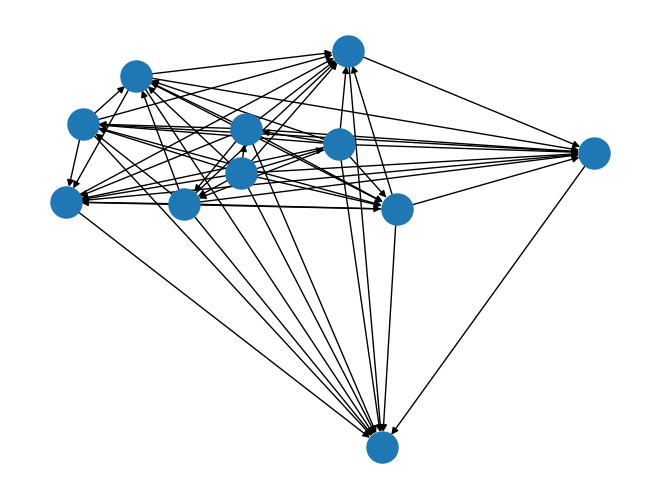

In [5]:
W = sempler.generators.dag_full(11)
show_graph_with_labels(W,None)

In [49]:
data

[array([[-7.14507463e-01, -2.83083805e+00,  1.11324915e+00,
         -5.98860147e-01],
        [-2.03714023e+00, -3.61998032e+00,  3.36875954e-01,
         -3.72670692e-01],
        [ 2.82831701e+00,  2.25290931e+00, -4.65946056e-01,
         -1.00925993e+00],
        [-2.24011181e+00, -4.32865351e+00,  3.51467555e-01,
         -1.73588293e+00],
        [-1.61261840e+00, -4.14241430e+00, -1.09504101e+00,
         -6.54068958e-01],
        [-6.88362891e-01, -2.17561244e+00, -1.92361690e-01,
         -1.54079505e+00],
        [-1.02397793e+00,  1.28386517e+00,  2.48847861e+00,
          3.53166740e+00],
        [ 4.83404394e-02,  5.45108212e+00,  2.30103205e+00,
          3.12662550e+00],
        [-7.00646695e-01, -1.70428644e+00,  1.86299282e-01,
         -3.19598546e-01],
        [-4.43105885e-01,  1.74019316e+00,  1.79124409e+00,
          1.34809058e+00],
        [-6.74334914e-01,  1.05769562e+00,  1.12378975e+00,
         -3.59251553e-01],
        [-1.36264667e+00,  3.63437027e-01, 

In [38]:
sempler.generators.dag_avg_deg()

array([[0.        , 0.        , 0.        , 0.        ],
       [1.57809844, 0.        , 0.69972899, 0.        ],
       [0.55784512, 0.        , 0.        , 0.        ],
       [1.03265489, 0.        , 1.13913881, 0.        ]])

In [36]:
log[['case:concept:name','concept:name','time:timestamp']]

case:concept:name                concept:name            time:timestamp
0                     A1                 Create Fine 2006-07-23 22:00:00+00:00
1                     A1                   Send Fine 2006-12-04 23:00:00+00:00
2                   A100                 Create Fine 2006-08-01 22:00:00+00:00
3                   A100                   Send Fine 2006-12-11 23:00:00+00:00
4                   A100    Insert Fine Notification 2007-01-14 23:00:00+00:00
...                  ...                         ...                       ...
561465             V9999                 Create Fine 2002-09-06 22:00:00+00:00
561466             V9999                   Send Fine 2002-10-24 22:00:00+00:00
561467             V9999    Insert Fine Notification 2002-11-03 23:00:00+00:00
561468             V9999                 Add penalty 2003-01-02 23:00:00+00:00
561469             V9999  Send for Credit Collection 2004-01-09 23:00:00+00:00

[561470 rows x 3 columns]

In [37]:
log['concept:name'].unique()

array(['Create Fine', 'Send Fine', 'Insert Fine Notification',
       'Add penalty', 'Send for Credit Collection', 'Payment',
       'Insert Date Appeal to Prefecture', 'Send Appeal to Prefecture',
       'Receive Result Appeal from Prefecture',
       'Notify Result Appeal to Offender', 'Appeal to Judge'],
      dtype=object)

# Toy example

y = f(x)

x = a*(create fine) + b*(send fine) + c*(categorical variable) + d*(numerical variable from gaussian)

In [10]:
r = np.random
r.seed(1)

In [13]:
p = 0.9
create_fine = r.choice([1,0],size=10000,p=[p,(1-p)])

In [14]:
p = 0.9
send_fine = r.choice([1,0],size=10000,p=[p,(1-p)])

In [19]:
p = [0.7,0.2,0.1]
dismissal = r.multinomial(1,pvals=p,size=10000)

In [24]:
amount = r.normal(size=10000,loc=30,scale=10)

In [27]:
data = pd.DataFrame(data=[create_fine,send_fine,dismissal[0],dismissal[1],dismissal[2],amount])

In [29]:
data

0          1          2         3          4          5         6     \
0   1.000000   1.000000   1.000000   1.00000   1.000000   1.000000   0.00000   
1   1.000000   1.000000   0.000000   1.00000   0.000000   1.000000   1.00000   
2   1.000000   0.000000   0.000000       NaN        NaN        NaN       NaN   
3   1.000000   0.000000   0.000000       NaN        NaN        NaN       NaN   
4   1.000000   0.000000   0.000000       NaN        NaN        NaN       NaN   
5  35.803733  15.925606  39.799707  27.21264  34.494517  43.906065  38.45408   

        7          8          9          10         11         12        13    \
0   1.000000   1.000000   1.000000   1.000000   1.000000   1.000000  1.000000   
1   1.000000   1.000000   1.000000   0.000000   1.000000   1.000000  1.000000   
2        NaN        NaN        NaN        NaN        NaN        NaN       NaN   
3        NaN        NaN        NaN        NaN        NaN        NaN       NaN   
4        NaN        NaN        NaN        NaN        NaN        NaN       NaN   
5  21.523409  28.214102  26.975186  33.005957  33.436613  10.913077  6.702773   

        14         15         16         17        18         19         20    \
0   1.000000   1.000000   1.000000   1.000000   1.00000   1.000000   1.000000   
1   1.000000   1.000000   0.000000   1.000000   1.00000   1.000000   1.000000   
2        NaN        NaN        NaN        NaN       NaN        NaN        NaN   
3        NaN        NaN        NaN        NaN       NaN        NaN        NaN   
4        NaN        NaN        NaN        NaN       NaN        NaN        NaN   
5  56.578512  48.729069  22.616143  11.829228  23.01069  26.040621  29.426067   

        21         22         23        24         25        26         27    \
0   0.000000   1.000000   1.000000  1.000000   1.000000   1.00000   1.000000   
1   1.000000   1.000000   1.000000  1.000000   1.000000   1.00000   1.000000   
2        NaN        NaN        NaN       NaN        NaN       NaN        NaN   
3        NaN        NaN        NaN       NaN        NaN       NaN        NaN   
4        NaN        NaN        NaN       NaN        NaN       NaN        NaN   
5  30.602729  46.516031  38.689358  6.253632  39.554198  38.78913  20.536667   

        28         29         30         31         32         33    \
0   1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   
1   1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   
2        NaN        NaN        NaN        NaN        NaN        NaN   
3        NaN        NaN        NaN        NaN        NaN        NaN   
4        NaN        NaN        NaN        NaN        NaN        NaN   
5  17.525218  38.235193  19.322847  38.895678  24.339779  38.094152   

        34         35         36         37         38         39    \
0   1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   
1   1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   
2        NaN        NaN        NaN        NaN        NaN        NaN   
3        NaN        NaN        NaN        NaN        NaN        NaN   
4        NaN        NaN        NaN        NaN        NaN        NaN   
5  31.120001  33.084058  39.066028  40.897732  15.727754  23.509213   

        40         41         42        43        44         45         46    \
0   1.000000   1.000000   1.000000   1.00000  1.000000   0.000000   1.000000   
1   1.000000   1.000000   1.000000   1.00000  1.000000   1.000000   1.000000   
2        NaN        NaN        NaN       NaN       NaN        NaN        NaN   
3        NaN        NaN        NaN       NaN       NaN        NaN        NaN   
4        NaN        NaN        NaN       NaN       NaN        NaN        NaN   
5  23.778475  37.225667  16.058348  16.73331  8.896405  20.162402  23.035623   

        47         48         49         50         51         52    \
0   1.000000   1.000000   1.000000   0.000000   1.000000   1.000000   
1   1.000000   1.000000   1.000000   0.000000   1.0